# Tutorial 2

## Questions from the tutorial earlier (please answer here)

**Question:** Are there Ns inside the 20bp regions flanking the Ns? If so, why do you think so?

**Answer:**

**Question:** After viewing the normal PAR regions, was your hypothesis correct?

**Answer:**

We'll now look briefly at how STAR and kallisto perform against one another, using some of the tools we learned in the last tutorial

## Load required packages

In [1]:
# Just as we did last week
import os
import re
import mygene
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text

In [2]:
# Set the present working directory with the getcwd() function from the os library
pwd = os.getcwd()

In [3]:
# Check this is set correctly to '/home/<SUNetID>/BIOC281/Classes/2'
pwd

'/home/sinhar/BIOC281/Classes/2'

## Data ingest

In [4]:
# Read in tab separated values table from STAR using the read_csv function from pandas (pd)
#
# The index_col=0 parameter tells pandas to use the first column as the rownames
# The header=0 parameter tells pandas the first row is real data, not the columns
# which we instead supply with the names parameter.
#
# The join() command from the path section of the os library allows us to construct file paths
# In this case it will return '/home/<SUNetID>/BIOC281/Classes/2/STAResults/male_1p/male.1p.ReadsPerGene.out.tab'
male_STAR = pd.read_csv(os.path.join(pwd, 'STAResults', 'male_1p', 'male.1p.ReadsPerGene.out.tab'), sep="\t", header=0, names=['feature', 'counts', 'pos', 'neg'], index_col=0)

# Read in tab separated values table from kallisto using the read_csv function from pandas (pd)
male_kallisto = pd.read_csv(os.path.join(pwd, 'kallistoResults', 'output', 'abundance.tsv'), sep="\t", index_col=0)

In [5]:
# Print the STAR data frame
#
# Note how STAR added some metadata, including the number of counts that mapped to multiple loci
# By default, STAR does not include these in the gene counts table
# STAR also reports whether counts came from the positive or negative strand
# Also note there are only 6,018 genes because our minigenome only included chromosomes 1, 2, X, Y, and mitochrondrial
male_STAR

,counts,pos,neg
feature,,,
N_multimapping,5423,5423,5423
N_noFeature,37188,57730,57755
N_ambiguous,912,303,265
WASH7P,6,3,3
MIR6859-1,0,0,0
...,...,...,...
ERCC-00164,0,0,0
ERCC-00165,28,14,14
ERCC-00168,0,0,0


In [6]:
# Print the kallisto data frame
#
# Note how kallisto has returned RefSeq transcript IDs rather than gene names
# It includes transctipts across the entire genome, which is why there are 86,486 features
# kallisto also supplies the actual and effective (detected) gene lengths (in bases)
# that is used to estimate transcripts per million (tpm)
# The est_counts column is the most directly comparable to STARs output
male_kallisto

,length,eff_length,est_counts,tpm
target_id,,,,
NR_024540,1769,1550.4500,0.0,0.000
NR_106918,68,55.1667,0.0,0.000
NR_107062,68,55.1667,0.0,0.000
NR_107063,68,55.1667,0.0,0.000
NR_128720,68,55.1667,0.0,0.000
...,...,...,...,...
ERCC-00164,1022,803.4490,0.0,0.000
ERCC-00165,872,653.4490,29.0,333.611
ERCC-00168,1024,805.4490,0.0,0.000


In [7]:
# The RefSeq IDs include a few duplicate entries that have underscores appended onto them (e.g. NR_024540_2)
# We use regular expressions to match and remove them (with the sub() function from the re library)
#
# In this case, the "^" symbol matches the start of each ID and the "$" symbol matches the end
# The two "[^_]+" match 1 or more characters that do not include an "_"
# The parentheses around them allowing us to reference them later
# The "_.*" matches any number of characters following a second "_"
#
# We then replace the matched sequence with the text that comes before the first "_" and
# then the text that comes after the first "_", but before the second "_"
#
# The renames RefSeq IDs are saved into a new column
male_kallisto['collapse_id'] = [re.sub('^([^_]+)_([^_]+)_.*$', '\\1_\\2', x) for x in male_kallisto.index.to_list()]

# Use pandas' groupby() and sum() functions to collapse counts with the same RefSeq ID to a single row
male_kallisto = male_kallisto.groupby('collapse_id').sum()

In [8]:
# Print the updated table, notice how the number of rows has changed
male_kallisto

,length,eff_length,est_counts,tpm
collapse_id,,,,
ERCC-00002,1061,842.449,4350.0,38815.000
ERCC-00003,1023,804.449,202.0,1887.590
ERCC-00004,523,304.934,326.0,8036.480
ERCC-00009,984,765.449,100.0,982.059
ERCC-00012,994,775.449,0.0,0.000
...,...,...,...,...
NR_169751,6321,6102.450,0.0,0.000
NR_169752,2090,1871.450,0.0,0.000
NR_169753,2357,2138.450,0.0,0.000


## Convert RefSeq IDs to gene names

In [9]:
# Connect to RefSeq using the mygene library (see https://mygene.info for more uses)
mg = mygene.MyGeneInfo()

# Create a table of RefSeq IDs and corresponding gene names with the querymany() function from mygene
# You can obtain the rownames from a pandas data frame with the index function
# and then convert them to a list (expected by mygene) with the tolist() function
refIDToGene = mg.querymany(male_kallisto.index.tolist(),
             scopes='refseq,symbol',
             species='human',
             as_dataframe=True)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-28000...done.
querying 28001-29000...done.
querying 29001-30000...done.
querying 30001-31000...done.
querying 31001-32000...done.
querying 32001-33000...done.
querying 33001-34000...done.
querying 34001-35000...done.
queryin

/home/sinhar/miniconda3/envs/singlecell/lib/python3.8/site-packages/biothings_client/base.py:143: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = json_normalize(obj)


97 input query terms found no hit:
	['ERCC-00002', 'ERCC-00003', 'ERCC-00004', 'ERCC-00009', 'ERCC-00012', 'ERCC-00013', 'ERCC-00014', '
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [10]:
# Print the table
# Notice how some entries (e.g. the ERCCs) did not have a matching gene symbol and were returned as NaNs)
refIDToGene

,notfound,_id,_score,entrezgene,name,symbol,taxid
query,,,,,,,
ERCC-00002,True,NaN,NaN,NaN,NaN,NaN,NaN
ERCC-00003,True,NaN,NaN,NaN,NaN,NaN,NaN
ERCC-00004,True,NaN,NaN,NaN,NaN,NaN,NaN
ERCC-00009,True,NaN,NaN,NaN,NaN,NaN,NaN
ERCC-00012,True,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
NR_169751,NaN,285600,3.966737,285600,KIAA0825,KIAA0825,9606.0
NR_169752,NaN,285600,3.968878,285600,KIAA0825,KIAA0825,9606.0
NR_169753,NaN,285600,3.966001,285600,KIAA0825,KIAA0825,9606.0


In [11]:
# Create a new column in the kallisto table that has the gene symbols for each RefSeq ID
# We again use index to obtain the rownames for the table
male_kallisto['symbol'] = refIDToGene.symbol[male_kallisto.index].to_list()

In [12]:
# Find rows without a gene symbol (those with NaNs) and set them to their current rowname
tmp = male_kallisto.symbol.copy()
tmp[tmp.isna()] = tmp[tmp.isna()].index.to_list()
male_kallisto.symbol = tmp.copy()

In [13]:
# Use pandas' groupby() and sum() functions to collapse counts with the same gene name to a single row
male_kallisto = male_kallisto.groupby('symbol').sum()

In [14]:
# Print the new kallisto table
# Notice how the number of rows has fallen to 28,402 (in line with the number of human genes)
male_kallisto

,length,eff_length,est_counts,tpm
symbol,,,,
A1BG,3382,3163.45,3.000000,7.128770
A1BG-AS1,2130,1911.45,0.000000,0.000000
A1CF,74551,72802.60,11.000026,9.231985
A2M,18482,17607.80,0.000000,0.000000
A2M-AS1,6769,6113.35,42.000000,160.391000
...,...,...,...,...
ZYG11A,8132,7694.90,0.000000,0.000000
ZYG11B,8143,7924.45,0.000000,0.000000
ZYX,6588,5932.35,4.000000,15.689800


## Merge the STAR and kallisto data and compare

In [15]:
# Identify the genes the STAR and kallisto data have in common (those on the minigenome)
tmp = male_STAR.index.intersection(male_kallisto.index)

# Subset both tables to only include those genes with the loc[] command from pandas
male_kallisto_common = male_kallisto.loc[tmp]
male_STAR_common = male_STAR.loc[tmp]

**Question:** After subsetting the kallisto table, are the transcript per millions values still OK to use?

**Answer:**

In [16]:
# Create a data frame that contains the STAR and kallisto absolute and log normalized counts as well as their absolute difference
tmp = pd.DataFrame()
tmp['STAR'] = male_STAR_common.counts
tmp['Kallisto'] = male_kallisto_common.est_counts
tmp['log_STAR'] = np.log10(tmp.STAR + 1)
tmp['log_Kallisto'] = np.log10(tmp.Kallisto + 1)
tmp['abs_diff'] = tmp.STAR - tmp.Kallisto

In [17]:
# Print the total counts mapped by STAR and kallisto to the minigenome
print('STAR counts: ' + str(tmp.STAR.sum()))
print('Kallisto counts: ' + str(tmp.Kallisto.sum()))

STAR counts: 40557
Kallisto counts: 46009.874232497605


**Note:** Kallisto does not have a whole number of counts because it uses probablistic mapping where a fraction of a read can be assigned to multiple transcripts

**Question:** How does the difference in the number of total counts between kallisto and STAR compare with the number of multimapping reads called by STAR (from above)?

**Answer:**

In [18]:
# Plot the pearson correlation between the STAR and kallisto results
print('Pearson counts: ' + str(sp.stats.pearsonr(tmp.STAR, tmp.Kallisto)))
print('Pearson log10(counts+1): ' + str(sp.stats.pearsonr(tmp.log_STAR, tmp.log_Kallisto)))

Pearson counts: (0.997316433546491, 0.0)
Pearson log10(counts+1): (0.9341010619706266, 0.0)


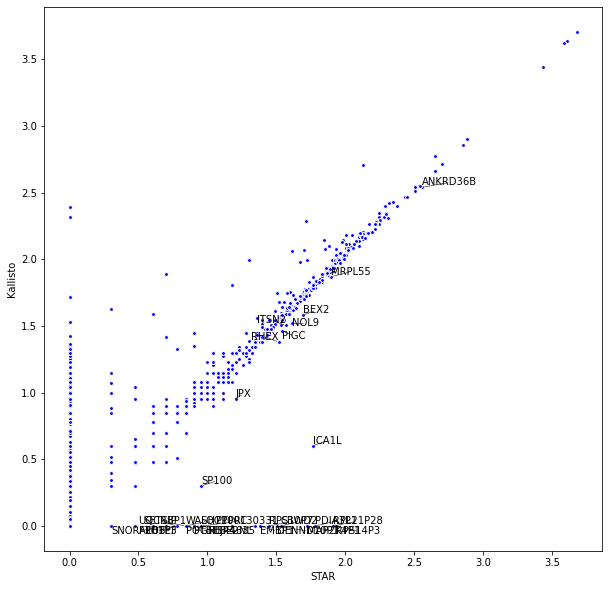

In [19]:
# Set the plotting size as we did last week
plt.rcParams['figure.figsize'] = [10, 10]

# Create a scatter plot comparing the log normalized counts
# s sets the size of the points, c sets the color (blue), and edgecolors sets their outline color
f = plt.figure()
scatter = plt.scatter(tmp.log_STAR, tmp.log_Kallisto, s=15, c='b', edgecolors='w')
plt.xlabel("STAR")
plt.ylabel("Kallisto")

# Label the 30 genes with the largest difference in STAR relative to kallisto using the adjust_text()
# function from the adjustText library so the names do not collide
#
# We use the sort_values() function from pandas to order the dataframe by the absolute difference
# sort_values() orders the genes in ascending order so the end contain those with the largest positive differemt
# [-30:] nabs the last 30 values
texts = []
to_plot = tmp.abs_diff.sort_values()[-30:].index
for x, y, s in zip(tmp.log_STAR[to_plot], tmp.log_Kallisto[to_plot], to_plot.to_series()):
    texts.append(plt.text(x, y, s))
    
adjust_text(texts, force_points=0.2, force_text=0.2,
            expand_points=(1, 1), expand_text=(1, 1),
            arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

plt.show()

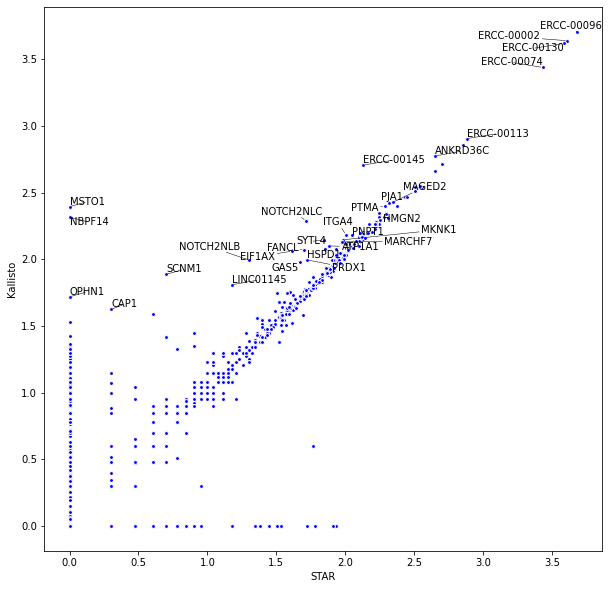

In [20]:
plt.rcParams['figure.figsize'] = [10, 10]

# Create a scatter plot comparing the log normalized counts
# s sets the size of the points, c sets the color (blue), and edgecolors sets their outline color
f = plt.figure()
scatter = plt.scatter(tmp.log_STAR, tmp.log_Kallisto, s=15, c='b', edgecolors='w')
plt.xlabel("STAR")
plt.ylabel("Kallisto")

# Label the 30 genes with the largest difference in kallisto relative to STAR using the adjust_text()
# function from the adjustText library so the names do not collide
#
# We use the sort_values() function from pandas to order the dataframe by the absolute difference
# sort_values() orders the genes in ascending order so the start contains those with the largest negative differemt
# [:30] nabs the first 30 values
texts = []
to_plot = tmp.abs_diff.sort_values()[:30].index
for x, y, s in zip(tmp.log_STAR[to_plot], tmp.log_Kallisto[to_plot], to_plot.to_series()):
    texts.append(plt.text(x, y, s))

adjust_text(texts, force_points=0.2, force_text=0.2,
            expand_points=(1, 1), expand_text=(1, 1),
            arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

plt.show()

In [21]:
# Print a table of the top 30 genes by absolute difference in STAR relative to kallisto
# As sort_values() places values in ascending order we use [::-1] to reverse the dataframe
tmp.loc[tmp.abs_diff.sort_values()[-30:].index[::-1], :]

,STAR,Kallisto,log_STAR,log_Kallisto,abs_diff
RPS14P3,85,0.000000,1.934498,0.000000,85.000000
RPL21P28,80,0.000000,1.908485,0.000000,80.000000
PDIA3P1,59,0.000000,1.778151,0.000000,59.000000
ICA1L,57,3.000001,1.763428,0.602060,53.999999
MAP2K4P1,52,0.000000,1.724276,0.000000,52.000000
CBWD2,33,0.000000,1.531479,0.000000,33.000000
DENND10P1,31,0.000000,1.505150,0.000000,31.000000
RPS10P7,27,0.000000,1.447158,0.000000,27.000000
EMBP1,23,0.000000,1.380211,0.000000,23.000000
FLJ44635,21,0.000000,1.342423,0.000000,21.000000


In [22]:
# Print a table of the top 30 genes by absolute difference in kallisto relative to STAR
tmp.loc[tmp.abs_diff.sort_values()[:30].index, :]

,STAR,Kallisto,log_STAR,log_Kallisto,abs_diff
ERCC-00145,134,508.000000,2.130334,2.706718,-374.000000
ERCC-00130,3855,4154.000000,3.586137,3.618571,-299.000000
ERCC-00096,4791,5065.000000,3.680517,3.704665,-274.000000
ERCC-00002,4094,4350.000000,3.612254,3.638589,-256.000000
MSTO1,0,246.999800,0.000000,2.394451,-246.999800
NBPF14,0,206.077000,0.000000,2.316132,-206.077000
ANKRD36C,444,593.199000,2.648360,2.773932,-149.199000
NOTCH2NLC,51,193.982600,1.716003,2.289996,-142.982600
NOTCH2NLB,19,97.788700,1.301030,1.994707,-78.788700
EIF1AX,40,114.000000,1.612784,2.060698,-74.000000


**Note:** When finished, please save the outputs of Tutorial 2.ipynb (File > Export Notebook As... > Export Notebook to HTML) when you have completed it and upload it to Canvas.